In [1]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [2]:
#@title **Location** of the dataset
path =  "../data/LendingClub/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"
backup_image_folder = "../../backup/Images/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os
import re
import logging



from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn.feature_selection import r_regression


In [4]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [6]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri
import credit_pipeline.evaluate as ev

from submodules.topsis_python import topsis as top

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

In [7]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 42050

main_seed = seed_number
print(seed_number)

42050


In [8]:
logpath = Path(os.path.join(ri_datasets_path,f'note23/{main_seed}_log.txt'))
logpath.parent.mkdir(parents=True, exist_ok=True)


# Configure logging to file
logging.basicConfig(filename=logpath, 
                    filemode='w',  # Overwrite the file each time the application runs
                    level=logging.DEBUG,  # Capture all levels of logging
                    format='%(asctime)s - %(levelname)s - %(message)s',  # Include timestamp, log level, and message
                    datefmt='%Y-%m-%d %H:%M:%S')  # Format for the timestamp


#Read Dataset

In [9]:
ls '../data/LendingClub/'

accepted_2007_to_2018Q4.csv  rejected_2007_to_2018Q4.csv


In [10]:
#Accepts

la = ["issue_d", "loan_amnt", "funded_amnt", "funded_amnt_inv", "term", "int_rate"]
lb = ["installment", "emp_length", "annual_inc", "verification_status", "loan_status", 
      "purpose", "addr_state", "dti", "delinq_2yrs"]
lc = ["inq_last_6mths", "open_acc", "home_ownership", "revol_bal", "revol_util",
       "total_acc", "total_pymnt", "total_rec_prncp", "total_rec_int", "total_pymnt_inv",
         "last_pymnt_amnt", "last_fico_range_high", "last_fico_range_low"]

selected_columns_a = la+lb+lc

# Define the chunk size for reading the CSV file
chunksize = 100000  # Adjust this value based on your requirements

# Initialize an empty list to store filtered chunks
filtered_chunks = []

# Read the CSV file in chunks based on the defined chunk size
for chunk in pd.read_csv(path+'accepted_2007_to_2018Q4.csv', chunksize=chunksize, usecols=selected_columns_a):
    # Filter the current chunk based on the criteria
    filtered_chunk = chunk[chunk['issue_d'].str.contains("2009", na=False)]
    # filtered_chunk = filtered_chunk[~filtered_chunk['issue_d'].str.contains("Oct-2013|Nov-2013|Dec-2013", na=False)]
    # Append the filtered chunk to the list
    filtered_chunks.append(filtered_chunk)

# Concatenate all filtered chunks into a single DataFrame
df_a = pd.concat(filtered_chunks)

# Now filtered_df contains only the rows that match the specified criteria
# print(df_a.issue_d.unique())
df_a


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,last_fico_range_high,last_fico_range_low
1645106,1000.0,1000.0,1000.000000,36 months,7.40,31.06,1 year,MORTGAGE,107000.0,Not Verified,...,4938.0,1.9,35.0,1006.220000,1006.22,1000.00,6.22,1006.28,774.0,770.0
1645112,7500.0,7500.0,7350.000000,36 months,7.05,231.75,1 year,RENT,12720.0,Not Verified,...,0.0,0.0,9.0,2073.270000,2031.77,1547.57,248.18,13.00,619.0,615.0
1645113,8700.0,8700.0,8550.000000,36 months,7.05,268.83,2 years,MORTGAGE,54000.0,Not Verified,...,3519.0,11.3,15.0,9538.399493,9373.95,8700.00,838.40,3633.76,799.0,795.0
1645118,7000.0,7000.0,6953.550000,36 months,12.18,233.10,4 years,RENT,30000.0,Not Verified,...,6601.0,58.2,15.0,1668.720000,1661.80,995.51,400.51,233.10,539.0,535.0
1645119,9000.0,9000.0,8850.000000,36 months,7.05,278.10,9 years,RENT,130000.0,Not Verified,...,4433.0,3.9,28.0,9768.408834,9605.60,9000.00,768.41,271.03,814.0,810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653227,15000.0,15000.0,11933.870000,36 months,11.89,497.46,9 years,MORTGAGE,90000.0,Verified,...,96473.0,48.1,23.0,17694.467802,13860.79,14999.99,2694.48,4776.14,749.0,745.0
1653228,15000.0,15000.0,7155.150000,36 months,16.63,532.05,10+ years,MORTGAGE,114000.0,Verified,...,107611.0,89.1,19.0,4095.940000,2126.30,1322.86,803.82,532.05,759.0,755.0
1653229,5000.0,5000.0,2675.000000,36 months,13.47,169.62,< 1 year,OTHER,12000.0,Not Verified,...,2905.0,25.5,10.0,1880.820000,1005.25,1318.37,544.29,184.62,564.0,560.0
1653231,9000.0,9000.0,5560.850626,36 months,8.00,282.03,5 years,MORTGAGE,100000.0,Verified,...,212878.0,5.8,26.0,10152.886036,6188.31,8999.99,1152.89,293.81,739.0,735.0


In [11]:
#Rejects
selected_columns_r = ["Application Date", "Debt-To-Income Ratio","State", "Risk_Score", "Amount Requested", "Employment Length"]

# Define the chunk size for reading the CSV file
chunksize = 100000  # Adjust this value based on your requirements

# Initialize an empty list to store filtered chunks
filtered_chunks = []

# Read the CSV file in chunks based on the defined chunk size
for chunk in pd.read_csv(path+'rejected_2007_to_2018Q4.csv', chunksize=chunksize, usecols=selected_columns_r):
    # Filter the current chunk based on the criteria
    chunk["Application Date"] = chunk["Application Date"].astype(str)
    filtered_chunk = chunk[chunk["Application Date"].str.contains("2009", na=False)]
    # filtered_chunk = filtered_chunk[~filtered_chunk["Application Date"].str.contains("2013-10|2013-11|2013-12", na=False)]
    # Append the filtered chunk to the list
    filtered_chunks.append(filtered_chunk)

# Concatenate all filtered chunks into a single DataFrame
df_r = pd.concat(filtered_chunks)

# Now filtered_df contains only the rows that match the specified criteria
df_r

,Amount Requested,Application Date,Risk_Score,Debt-To-Income Ratio,State,Employment Length
30870,9000.0,2009-01-01,517.0,0.51%,MA,3 years
30871,12000.0,2009-01-01,646.0,10.22%,RI,1 year
30872,10000.0,2009-01-01,NaN,-1%,HI,10+ years
30873,15000.0,2009-01-01,556.0,7.07%,FL,10+ years
30874,5000.0,2009-01-01,546.0,12.26%,PA,9 years
...,...,...,...,...,...,...
87856,1000.0,2009-12-31,679.0,43.8%,IL,< 1 year
87857,10000.0,2009-12-31,631.0,9.78%,IL,1 year
87858,7500.0,2009-12-31,646.0,6.66%,CA,3 years
87859,10000.0,2009-12-31,556.0,2.55%,NH,< 1 year


In [12]:
# df_a_B, df_r_B = df_a.copy(), df_r.copy()
# df_a, df_r = df_a_B.copy(), df_r_B.copy() 

In [13]:
dex.get_shapes(df_a, df_r)

__ : (5281, 28)
_ : (56991, 6)


In [14]:
#rejected fix names
df_r["emp_length"] = df_r["Employment Length"]
df_r["addr_state"] = df_r["State"]
df_r["dti"] = df_r["Debt-To-Income Ratio"]
df_r["dti"] = pd.to_numeric(df_r['dti'].str.replace('%', ''))
df_r["loan_amnt"] = df_r["Amount Requested"]
df_r["risk_score"] = df_r["Risk_Score"]
df_r["issue_d"] = df_r["Application Date"]

#accepted fix names
df_a["risk_score"] = df_a.loc[:,["last_fico_range_high","last_fico_range_low"]].mean(axis=1)
df_a["target"] = np.where((df_a.loan_status == 'Current') |
                        (df_a.loan_status == 'Fully Paid') |
                        (df_a.loan_status== "Issued") |
                        (df_a.loan_status == 'Does not meet the credit policy. Status:Fully Paid'), 0, 1)


In [15]:
df_a_B, df_r_B = df_a.copy(), df_r.copy()

In [16]:
df_a, df_r = df_a_B.copy(), df_r_B.copy() 

In [17]:
for c in ["Amount Requested", "Employment Length", "State",
                   "Debt-To-Income Ratio", "Amount Requested","Risk_Score", "Application Date"]:
    try:
        df_r = df_r.drop(c, axis = 1)
    except Exception as e:
        pass
for c in ['last_fico_range_high', 'last_fico_range_low', 'loan_status']:
    try:
        df_a = df_a.drop(c, axis = 1)
    except Exception as e:
        pass


# columns based on Shih et al. (2022)
r_cols = df_r.columns.to_list()
pearson_a = ['int_rate', 'dti', 'delinq_2yrs', 'emp_length', 'annual_inc', 'inq_last_6mths', 'term',
 'home_ownership','revol_util', 'risk_score', 'target', 'issue_d']
# pearson_a = ['int_rate', 'dti', 'delinq_2yrs', 'target']
# pearson_a = df_a.columns


union_list = r_cols.copy()

for item in pearson_a:
    if item not in union_list:
        union_list.append(item)
# Now union_list contains all elements from r_cols first, followed by those unique to pearson_a

df_a = df_a.loc[:, union_list]
df_a

,emp_length,addr_state,dti,loan_amnt,risk_score,issue_d,int_rate,delinq_2yrs,annual_inc,inq_last_6mths,term,home_ownership,revol_util,target
1645106,1 year,TX,0.96,1000.0,772.0,Dec-2009,7.40,0.0,107000.0,1.0,36 months,MORTGAGE,1.9,0
1645112,1 year,FL,0.00,7500.0,617.0,Dec-2009,7.05,0.0,12720.0,3.0,36 months,RENT,0.0,1
1645113,2 years,TX,2.67,8700.0,797.0,Dec-2009,7.05,0.0,54000.0,0.0,36 months,MORTGAGE,11.3,0
1645118,4 years,WA,19.36,7000.0,537.0,Dec-2009,12.18,0.0,30000.0,1.0,36 months,RENT,58.2,1
1645119,9 years,CA,4.98,9000.0,812.0,Dec-2009,7.05,0.0,130000.0,0.0,36 months,RENT,3.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1653227,9 years,AK,17.11,15000.0,747.0,Jan-2009,11.89,0.0,90000.0,1.0,36 months,MORTGAGE,48.1,0
1653228,10+ years,MS,21.95,15000.0,757.0,Jan-2009,16.63,0.0,114000.0,6.0,36 months,MORTGAGE,89.1,1
1653229,< 1 year,CA,9.90,5000.0,562.0,Jan-2009,13.47,0.0,12000.0,4.0,36 months,OTHER,25.5,1
1653231,5 years,FL,23.90,9000.0,737.0,Jan-2009,8.00,0.0,100000.0,2.0,36 months,MORTGAGE,5.8,0


In [18]:
# #rearrange columns order in df_a to match df_r

# new_column_order = list(df_r.columns)

# # Extend with any columns from df_a that aren't in df_r
# new_column_order += list(df_a.columns.difference(df_r.columns))
# new_column_order.remove('target')
# new_column_order.append('target')

# df_a = df_a.reindex(columns=new_column_order)

In [19]:
# #Fix dtype of variable emp_length (Object -> number)
try:
    df_a['emp_length'] = df_a['emp_length'].map(lambda x: "0" if x == '< 1 year' else x)
    df_a['emp_length'] = df_a['emp_length'].map(lambda x : int(re.search(r'\d+', x).group()), na_action='ignore')

    df_r['emp_length'] = df_r['emp_length'].map(lambda x: "0" if x == '< 1 year' else x)
    df_r['emp_length'] = df_r['emp_length'].map(lambda x : int(re.search(r'\d+', x).group()), na_action='ignore')
except Exception as e:
    print(e)

try:
    df_a['term'] = df_a['term'].map(lambda x : int(re.search(r'\d+', x).group()))
except Exception as e:
    print(e)

In [20]:
# df_a_B, df_r_B = df_a.copy(), df_r.copy()
# df_a, df_r = df_a_B.copy(), df_r_B.copy() 

In [21]:
#add missing columns to df_r
input_columns = df_a.columns.difference(df_r.columns).to_list()
input_columns.remove('target')

for col in input_columns:
    df_r.insert(df_r.columns.shape[0], col, np.nan)

In [22]:
dex.get_shapes(df_a, df_r)

_ : (5281, 14)
df_r : (56991, 13)


In [23]:
check_acp = df_a.copy()
check_rej = df_r.copy()

#Params

In [24]:
params_dict = ri.params_dict

In [25]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

params_dict['RandomForest_1'] = {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None,
                        'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2',
                        'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0,
                        'min_samples_leaf': 9, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0,
                        'n_estimators': 173, 'n_jobs': -1, 'oob_score': False, 'random_state': seed_number,
                        'verbose': 0, 'warm_start': False},

In [26]:
# df_a_B, df_r_B = df_a.copy(), df_r.copy()
# df_a, df_r = df_a_B.copy(), df_r_B.copy()



# End of Essential Cells

In [27]:
# #inputer
# X = df_a.loc[:, df_a.columns != "target"]
# y = df_a["target"]

# clf = tr.create_pipeline(X, y, LGBMClassifier(**params_dict['LightGBM_2']), do_EBE=True, crit = 0)
# clf = clf.fit(X, y,)
# X_trf = clf[:-1].transform(X)
# cols_trf = clf[:-1].get_feature_names_out()
# pr = r_regression(X_trf, y)
# dict_pr = {i: j for i, j in zip(cols_trf, pr)}
# pdf = pd.DataFrame([dict_pr], index=['pr_value'])
# selected_cols = pdf.T.abs().sort_values(by= 'pr_value', ascending=False).head(1).index.to_list()
# df_a = df_a.loc[:,selected_cols + ['target']]
# df_r = df_r.loc[:,selected_cols]


In [28]:
try:
    train_rej = df_r[~df_r['issue_d'].str.contains("2009-10|2009-11|2009-12", na=False)]
    train_acp = df_a[~df_a['issue_d'].str.contains("Oct-2009|Nov-2009|Dec-2009", na=False)]

    test_rej = df_r[df_r['issue_d'].str.contains("2009-10|2009-11|2009-12", na=False)]
    test_acp = df_a[df_a['issue_d'].str.contains("Oct-2009|Nov-2009|Dec-2009", na=False)]
except Exception as e:
    print(e)

In [29]:
train_r, train_a, test_r, test_a = train_rej.copy(), train_acp.copy(), test_rej.copy(), test_acp.copy()

for df in [train_r, train_a, test_r, test_a]:
    try:
        df.drop('issue_d', axis = 1, inplace=True)
    except Exception as e:
        pass

In [30]:
X_train = train_a.loc[:, train_a.columns != "target"]
y = train_a["target"]
X_test = test_a.loc[:, test_a.columns != "target"]
y_test = test_a["target"]

In [31]:
knn_inputer = tr.create_pipeline(X_train,y, None, do_EBE=True, crit = 0, do_KNN=True)
knn_inputer.fit(X_train,y)
X_train_knn = knn_inputer[:-3].transform(X_train)
X_test_knn = knn_inputer[:-3].transform(X_test)
R_train_knn = knn_inputer[:-3].transform(train_r)
R_test_knn = knn_inputer[:-3].transform(test_r)


In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_knn, y, test_size=0.3, random_state=main_seed, shuffle=True)
R_train, R_val = train_test_split(
    R_train_knn, test_size=0.3, random_state=main_seed, shuffle=True)

In [33]:
def code1():
    # X_train = df_train.loc[:, df_train.columns != "target"]
    # X_test = df_test.loc[:, df_test.columns != "target"]
    # X_val = df_val.loc[:, df_val.columns != "target"]

    # y_train, y_test, y_val = df_train["target"], df_test["target"], df_val["target"]
    # print([i.mean() for i in [y_train, y_test, y_val]])
    pass

In [34]:
models_dict = {}

#classifier
benchmark = tr.create_pipeline(X_train, y_train, LGBMClassifier(**params_dict['LightGBM_2']))
benchmark.fit(X_train, y_train)

#models
models_dict['BM'] = benchmark

In [35]:
models_dict.update(
    ri.augmentation_with_soft_cutoff(X_train, y_train, R_train, seed = seed_number))

In [36]:
models_dict.keys()

dict_keys(['BM', 'A-SC'])

In [37]:
p_acp, p_all = ri.pre_kickout(models_dict['BM'], models_dict['A-SC'], X_val, R_val)

In [38]:
k_list = []
for a in range(1,100):
    ar = a/100
    k, kg, kb = ri.faster_kickout(y_val, p_acp, p_all, acp_rate=ar)
    k_list.append(round(k, 3))
print(k_list)

[0.007, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.011, 0.012, 0.012, 0.013, 0.013, 0.014, 0.014, 0.015, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, -0.002, 0, 0, 0, 0, 0, 0, -0.003, -0.003, -0.003, -0.003, 0, 0, 0, -0.003, -0.003, -0.003, -0.003, -0.003, -0.004, -0.004, -0.004, -0.004, -0.004, -0.004, 0, 0, 0, -0.005, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.1]


In [140]:
models_dict.update(
    ri.augmentation_with_soft_cutoff(X_train, y_train, R_train, seed = seed_number))
logging.debug(f'augmentation_with_soft_cutoff fitted')
models_dict.update(
    ri.augmentation(X_train, y_train, R_train, mode='up', seed = seed_number))
logging.debug(f'augmentation upward fitted')
models_dict.update(
    ri.fuzzy_augmentation(X_train, y_train, R_train, seed = seed_number))
logging.debug(f'fuzzy_augmentation fitted')
models_dict.update(
    ri.extrapolation(X_train, y_train, R_train, seed = seed_number))
logging.debug(f'extrapolation fitted')
models_dict.update(
    ri.parcelling(X_train, y_train, R_train, seed = seed_number))
logging.debug(f'parcelling fitted')
models_dict.update(
    ri.label_spreading(X_train, y_train, R_train, seed = seed_number))
logging.debug(f'label_spreading fitted')

In [40]:
y_true = y_val.copy()

In [41]:
preds = {}
probs = {}

In [42]:
for mname, mmodel in models_dict.items():
    y_prob = mmodel.predict_proba(X_val)[:,1]
    probs[f'{mname}'] = y_prob
    preds[f'{mname}'] = (y_prob >= 0.5).astype('int')

In [186]:
kick_by_model_dict = {}
for mname, mmodel in models_dict.items():
    p_acp, p_all = ri.pre_kickout(models_dict['BM'], models_dict[mname], X_test_knn, R_val)
    ar_dict = {}
    for a in range(50, 70):
        AR = a/100
        kick_value = ri.faster_kickout(y_test, p_acp, p_all, acp_rate=AR)[0]
        ar_dict[a] = kick_value

    kick_by_model_dict[mname] = ar_dict

df_kick_by_model = pd.DataFrame(kick_by_model_dict)

In [187]:
df_kick_by_model.loc[50]

BM       0.000000
TN_10    0.146069
A-SC    -0.001089
A-UW     0.000000
A-FU     0.000000
E-C      0.000000
PAR      0.000000
LSP      0.104922
Name: 50, dtype: float64

In [188]:
ri.get_metrics_RI(models_dict, X_test_knn, y_test, X_unl=R_val, acp_rate=0.5)

,BM,TN_10,A-SC,A-UW,A-FU,E-C,PAR,LSP
Overall AUC,0.775423,0.768193,0.768891,0.775214,0.782811,0.776302,0.782920,0.652872
KS,0.422128,0.398542,0.413125,0.421912,0.455530,0.438361,0.452601,0.228675
Balanced Accuracy,0.711064,0.699271,0.706562,0.710956,0.727765,0.719180,0.726301,0.614338
Accuracy,0.637214,0.738046,0.718295,0.642412,0.706341,0.713098,0.671518,0.476091
Precision,0.251732,0.297251,0.287267,0.253521,0.288762,0.289318,0.270781,0.184300
Recall,0.813433,0.645522,0.690299,0.805970,0.757463,0.727612,0.802239,0.805970
F1,0.384480,0.407059,0.405702,0.385714,0.418126,0.414013,0.404896,0.300000
Kickout,0.000000,0.146069,-0.001089,0.000000,0.000000,0.000000,0.000000,0.104922
KG,0.000000,158.000000,1.000000,0.000000,0.000000,0.000000,0.000000,467.000000
KB,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.000000


In [45]:
ar_dict = { f'BM' : models_dict['BM'],
                f'BM' : models_dict['BM'],}
df_met = ri.get_metrics_RI(ar_dict, X_val, y_val, X_unl=R_val, acp_rate=AR)

In [46]:
for a_r in range(40,60):
   AR = a_r/100
   models_dict[f'TN-{a_r}'] = ri.trusted_non_outliers(X_train=X_train, y_train=y_train, X_unl=R_train,
                                       X_val=X_val, y_val=y_val, iterations=20,p=0.2, acp_rate=AR,
                                       technique='extrapolation', seed=seed_number, output='best')['TN']
   ar_dict = { f'BM' : models_dict['BM'],
               f'TN-{a_r}' : models_dict[f'TN-{a_r}']}
   df_ar = ri.get_metrics_RI(ar_dict, X_val, y_val, X_unl=R_val, acp_rate=AR)
   df_ar = df_ar.drop('BM', axis=1)
   df_met = pd.concat([df_met, df_ar], axis=1)

[0.75296735 0.25692799]
[0.75119226 0.17008344]
best iteration: 14
[0.75296735 0.20837034]
[0.75119226 0.15402975]
best iteration: 14
[0.75687747 0.21531532]
[0.75296735 0.19369369]
best iteration: 13
[0.75296735 0.22477064]
[0.75119226 0.19174312]
best iteration: 14
[0.75296735 0.23613707]
[0.75119226 0.22834891]
best iteration: 14
[0.75687747 0.20709322]
[0.75296735 0.1959486 ]
best iteration: 13
[0.76284899 0.19312169]
[0.76198189 0.14450164]
best iteration: 10
[0.7585135  0.26313725]
[0.75687747 0.14      ]
best iteration: 12
[0.76284899 0.23278443]
[0.76198189 0.16716567]
best iteration: 10
[0.7585135  0.22092612]
[0.75687747 0.17417815]
best iteration: 12
[0.7585135  0.24920908]
[0.75687747 0.19515502]
best iteration: 12
[0.7585135  0.26675655]
[0.75687747 0.2116718 ]
best iteration: 12
[0.7585135  0.25517241]
[0.75687747 0.14482759]
best iteration: 12
[0.76198189 0.24823789]
[0.7585135  0.24317181]
best iteration: 11
[0.75687747 0.29863986]
[0.75296735 0.23217031]
best iteration

In [106]:
low_AR, high_AR = 10,95
weights = [1,1]
criterias = np.array([True, True])

filepath_ex = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
# filepath_ls = Path(os.path.join(ri_datasets_path,f'TN+-{seed_number}.joblib'))

models_ex = joblib.load(filepath_ex)
# models_ls = joblib.load(filepath_ls)
def evaluate_best_it(models, X_val, y_val, R_val, low_AR, high_AR, weights, criterias):
    output_dict = {}
    values = []

    for it in list(models.keys()):
        ar_dict = {}
        auc_value = roc_auc_score(y_val, models[it].predict_proba(X_val)[:,1])
        p_acp, p_all = ri.pre_kickout(models['BM'], models[it], X_val, R_val)
        for a in range(low_AR, high_AR):
            AR = a/100
            kick_value = ri.faster_kickout(y_val, p_acp, p_all, acp_rate=AR)[0]
            ar_dict[a] = kick_value
        it_values = [auc_value, ar_dict]
        values.append(it_values)
        
    values = np.array(values)
    
    for a in range(low_AR, high_AR):
        values_by_ar = [[j,k] for j,k in zip(values[:,0],[i[a] for i in values[:,1]])]
        t = top.Topsis(values_by_ar, weights, criterias)
        t.calc()
        output = t.rank_to_best_similarity()[0] - 1
        output_dict[a] = output
        logging.debug(f'best iteration for AR {a} : {output}')
    return output_dict

output_ex = evaluate_best_it(models_ex, X_val, y_val, R_val, low_AR, high_AR, weights, criterias)
# output_ls = evaluate_best_it(models_ls, X_val, y_val, R_val, AR, weights)


In [234]:
output_ex

{10: 10,
 11: 10,
 12: 10,
 13: 10,
 14: 10,
 15: 18,
 16: 10,
 17: 10,
 18: 12,
 19: 17,
 20: 11,
 21: 12,
 22: 11,
 23: 11,
 24: 10,
 25: 10,
 26: 19,
 27: 18,
 28: 20,
 29: 18,
 30: 18,
 31: 18,
 32: 19,
 33: 20,
 34: 20,
 35: 18,
 36: 17,
 37: 17,
 38: 16,
 39: 19,
 40: 15,
 41: 15,
 42: 14,
 43: 14,
 44: 14,
 45: 15,
 46: 14,
 47: 11,
 48: 11,
 49: 11,
 50: 13,
 51: 18,
 52: 13,
 53: 13,
 54: 14,
 55: 14,
 56: 12,
 57: 12,
 58: 12,
 59: 14,
 60: 11,
 61: 9,
 62: 12,
 63: 10,
 64: 9,
 65: 9,
 66: 10,
 67: 9,
 68: 8,
 69: 8,
 70: 8,
 71: 7,
 72: 7,
 73: 6,
 74: 5,
 75: 5,
 76: 4,
 77: 4,
 78: 4,
 79: 4,
 80: 4,
 81: 4,
 82: 3,
 83: 2,
 84: 2,
 85: 6,
 86: 6,
 87: 5,
 88: 5,
 89: 5,
 90: 4,
 91: 4,
 92: 4,
 93: 4,
 94: 3}

In [114]:
models_ex[f'TN_{output_ex[a]}']

Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['emp_length', 'addr_state',
                                                   'dti', 'loan_amnt',
                                                   'risk_score', 'int_rate',
                                                   'delinq_2yrs', 'annual_inc',
                                                   'inq_last_6mths', 'term',
                                                   'home_ownership',
                                                   'revol_util']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('ebe',
                                                  P...
                                                  [])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=42050,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [283]:
models_dict_ex = {'BM': models_ex['BM']}
# models_dict_ls = {'BM': models_ls['BM']}
for a in range(low_AR, low_AR+20):
    models_dict_ex[a] = models_ex[f'TN_{output_ex[a]}']
    # models_dict_ls[a] = models_dict_ls[f'TN_{output_ex[a]}']

for a in range(low_AR, low_AR+20):
    AR = a/100
    keys_to_extract = ['BM', a]
    sub_dict_ex = {k: models_dict_ex[k] for k in keys_to_extract if k in models_dict_ex}
    ar_ex = ri.get_metrics_RI(sub_dict_ex, X_val, y_val, X_unl = R_val,
                                                    acp_rate=AR, threshold_type='none')
    
    # sub_dict_ls = {k: models_dict_ls[k] for k in keys_to_extract if k in models_dict_ls}
    # ar_ls = ri.get_metrics_RI(sub_dict_ls, X_val, y_val, X_unl = R_val,
    #                                                 acp_rate=AR, threshold_type='none')

    if a == low_AR:
        df_ex = ar_ex.loc[:,'BM']
        # df_ls = ar_ls.loc[:,'BM']

    ar_ex = ar_ex.drop('BM', axis=1)
    print(df_ex)
    # ar_ls = ar_ls.drop('BM', axis=1)
    
    df_ex = pd.concat([df_ex, ar_ex], axis=1)
    # df_met = pd.concat([df_ls, ar_ls], axis=1)

Overall AUC    0.775029
KS             0.440477
Kickout        0.000000
KG             0.000000
KB             0.000000
Name: BM, dtype: float64
                   BM        10
Overall AUC  0.775029  0.765360
KS           0.440477  0.407814
Kickout      0.000000  0.000000
KG           0.000000  0.000000
KB           0.000000  0.000000
                   BM        10        11
Overall AUC  0.775029  0.765360  0.765360
KS           0.440477  0.407814  0.407814
Kickout      0.000000  0.000000  0.000000
KG           0.000000  0.000000  0.000000
KB           0.000000  0.000000  0.000000
                   BM        10        11        12
Overall AUC  0.775029  0.765360  0.765360  0.765360
KS           0.440477  0.407814  0.407814  0.407814
Kickout      0.000000  0.000000  0.000000  0.000000
KG           0.000000  0.000000  0.000000  0.000000
KB           0.000000  0.000000  0.000000  0.000000
                   BM        10        11        12        13
Overall AUC  0.775029  0.765360  0.76

In [256]:
models_dict = {'BM': models_ex['BM']}
for a in range(low_AR, high_AR):
    models_dict[a] = models_ex[f'TN_{output_ex[a]}']

In [270]:
df_list = []
for a in range(low_AR, high_AR):
    AR = a/100
    keys_to_extract = ['BM', a]
    sub_dict = {k: models_dict[k] for k in keys_to_extract if k in models_dict}
    df_ar = ri.get_metrics_RI(sub_dict, X_val, y_val, X_unl = R_val,
                                                    acp_rate=AR, threshold_type='none')
    if a == low_AR:
        df_met = df_ar.loc[:,'BM']
    df_ar = df_ar.drop('BM', axis=1)
    
    df_met = pd.concat([df_met, df_ar], axis=1)
df_met

,BM,10,11,12,13,14,15,16,17,18,...,85,86,87,88,89,90,91,92,93,94
Overall AUC,0.775029,0.765360,0.765360,0.765360,0.765360,0.765360,0.748133,0.765360,0.765360,0.761982,...,0.776338,0.776338,0.780175,0.780175,0.780175,0.777631,0.777631,0.777631,0.777631,0.779348
KS,0.440477,0.407814,0.407814,0.407814,0.407814,0.407814,0.374905,0.407814,0.407814,0.389261,...,0.426759,0.426759,0.446809,0.446809,0.446809,0.441091,0.441091,0.441091,0.441091,0.442956
Kickout,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.012048,0.012500,0.024007,...,0.146667,0.100000,0.200000,0.159664,0.082569,0.282828,0.166667,0.087500,0.042857,0.283333
KG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,128.000000,126.000000,104.000000,100.000000,100.000000,71.000000,75.000000,73.000000,67.000000,43.000000
KB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [252]:
ri.get_metrics_RI(models_dict, X_val, y_val, X_unl=R_val, acp_rate=0.49).to_dict()

{'BM': {'Overall AUC': 0.7750292440714291,
  'KS': 0.44047706692188765,
  'Balanced Accuracy': 0.7202385334609438,
  'Accuracy': 0.7281746031746031,
  'Precision': 0.3003003003003003,
  'Recall': 0.7092198581560284,
  'F1': 0.4219409282700422,
  'Kickout': 0.0,
  'KG': 0.0,
  'KB': 0.0},
 40: {'Overall AUC': 0.7529673529820773,
  'KS': 0.3774816559915581,
  'Balanced Accuracy': 0.688740827995779,
  'Accuracy': 0.5922619047619048,
  'Precision': 0.23107569721115537,
  'Recall': 0.8226950354609929,
  'F1': 0.3608087091757387,
  'Kickout': 0.1416578296217745,
  'KG': 187.0,
  'KB': 12.0},
 41: {'Overall AUC': 0.7529673529820773,
  'KS': 0.3774816559915581,
  'Balanced Accuracy': 0.688740827995779,
  'Accuracy': 0.5922619047619048,
  'Precision': 0.23107569721115537,
  'Recall': 0.8226950354609929,
  'F1': 0.3608087091757387,
  'Kickout': 0.1416578296217745,
  'KG': 187.0,
  'KB': 12.0},
 42: {'Overall AUC': 0.7568774693857518,
  'KS': 0.3820952661415004,
  'Balanced Accuracy': 0.691047633

In [191]:
models_ex.keys()

dict_keys(['BM', 'TN_1', 'TN_2', 'TN_3', 'TN_4', 'TN_5', 'TN_6', 'TN_7', 'TN_8', 'TN_9', 'TN_10', 'TN_11', 'TN_12', 'TN_13', 'TN_14', 'TN_15', 'TN_16', 'TN_17', 'TN_18', 'TN_19', 'TN_20'])

In [230]:
TN_dict = {}
for it in list(models_ex.keys()):    
    p_acp, p_all = ri.pre_kickout(models_ex['BM'], models_ex[it], X_val, R_val)
    for a in range(low_AR, high_AR):
        AR = a/100
        kick_value = ri.faster_kickout(y_val, p_acp, p_all, acp_rate=AR)[0]
        ar_dict[AR] = kick_value
    TN_dict[it] = ar_dict
tdf = pd.DataFrame(TN_dict)

In [284]:
TN_dict = {}
for it in models_ex.keys():
    # Generate predictions for model 'BM' and current model 'it'
    p_acp, p_all = ri.pre_kickout(models_ex['BM'], models_ex[it], X_val, R_val)

    ar_dict = {}
    for a in range(45, 55):
        AR = a / 100
        # Calculate kickout value
        kick_value = ri.faster_kickout(y_val, p_acp, p_all, acp_rate=AR)[0]
        ar_dict[AR] = kick_value

    # Store the results for the current 'it'
    TN_dict[it] = ar_dict

ARs = sorted(ar_dict.keys())
tdf = pd.DataFrame(TN_dict, index=ARs)

In [216]:
for it in list(models_ex.keys()):    
    print(it)

BM
TN_1
TN_2
TN_3
TN_4
TN_5
TN_6
TN_7
TN_8
TN_9
TN_10
TN_11
TN_12
TN_13
TN_14
TN_15
TN_16
TN_17
TN_18
TN_19
TN_20


In [192]:
df_list = []
for a in range(low_AR, high_AR):
    AR = a/100
    df_ar = ri.get_metrics_RI(models_ex, X_val, y_val, X_unl = R_val,
                                                    acp_rate=AR, threshold_type='none')
    if a == low_AR:
        df_met = df_ar.loc[:,'BM']
    df_ar = df_ar.drop('BM', axis=1)
    
    df_met = pd.concat([df_met, df_ar], axis=1)

In [195]:
df_ar

,TN_1,TN_2,TN_3,TN_4,TN_5,TN_6,TN_7,TN_8,TN_9,TN_10,TN_11,TN_12,TN_13,TN_14,TN_15,TN_16,TN_17,TN_18,TN_19,TN_20
Overall AUC,0.767790,0.767135,0.779348,0.777631,0.780175,0.776338,0.771291,0.770260,0.768011,0.765360,0.762849,0.761982,0.758514,0.756877,0.752967,0.751192,0.748321,0.748133,0.741065,0.738889
KS,0.428305,0.439078,0.442956,0.441091,0.446809,0.426759,0.415544,0.412746,0.413483,0.407814,0.403838,0.389261,0.381703,0.382095,0.377482,0.364230,0.380328,0.374905,0.355886,0.347272
Kickout,0.000000,-0.183333,0.283333,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
KG,0.000000,11.000000,43.000000,59.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
KB,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
len(output_ex[1])

20

In [79]:
[i[50] for i in output_ex[:,1]]

[0,
 0,
 -0.0062370062370062365,
 0.02684624423754859,
 0.003977221368525722,
 0.03290246768507639,
 0.09075296031817773,
 0.04085691042212784,
 0.18150592063635546,
 0.14200488113531595,
 0.20609238000542354,
 0.12519208171382093,
 0.2244418331374853,
 0.18286179155744378,
 0.1639699900569466,
 0.11407394016089674,
 0.13658139745096268,
 0.19651089216306614,
 0.16722408026755864,
 0.17951730995209264]

In [65]:
clf = tr.create_pipeline(X_train, y_train, LGBMClassifier(**params_dict['LightGBM_2']), do_EBE=True)
clf = clf.fit(X_train, y_train)
X_train_trf = clf[:-1].transform(X_train)
cols_train_trf = clf[:-1].get_feature_names_out()
pr = r_regression(X_train_trf, y_train)
dict_pr = {i: j for i, j in zip(cols_train_trf, pr)}
dict_pr
pdf = pd.DataFrame([dict_pr], index=['pr_value'])
pdf.T.abs().sort_values(by= 'pr_value', ascending=False).head(10)

,pr_value
risk_score,0.300483
int_rate,0.159123
addr_state,0.150381
revol_util,0.081022
inq_last_6mths,0.074987
dti,0.059817
loan_amnt,0.057608
emp_length,0.044338
home_ownership,0.039778
annual_inc,0.033552


In [62]:
outliers_dict = {}
for i in range(1,50):
    c_t = i/100
    number = 1
    iso_params = {"contamination": c_t, "random_state":42010}
    iso = tr.create_pipeline(X_train[y_train == number], y_train[y_train == number],
                                            IsolationForest(**iso_params), do_EBE=True, crit = 0)
    iso.fit(X_train[y_train == number], y_train[y_train == number])
    # Retrieve the samples marked as non-outliers for training
    unl_scores = iso.predict(R_val)
    X_retrieved = R_val[unl_scores == -1]
    n_non_out = X_retrieved.shape[0]
    logging.debug(f'%outliers for {number} with contamination {c_t} : {n_non_out/R_val.shape[0]}')
    outliers_dict[c_t] = n_non_out/R_val.shape[0]

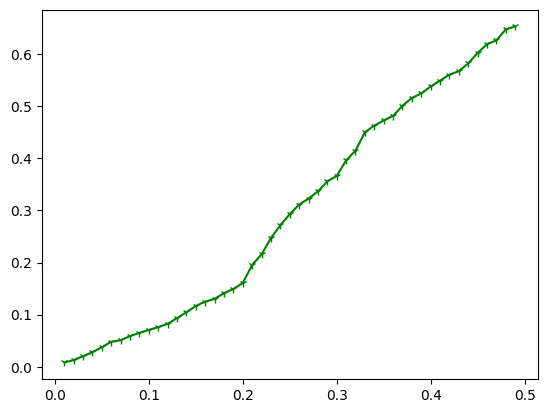

In [63]:
plt.plot(outliers_dict.keys(), outliers_dict.values(), label='% Outliers', color='green', marker='1')

# <font color='red'>Definition of Train and Test Val, and Unl</font>

In [42]:
hash(check_acp.to_string()) == hash(df_a.to_string()) and hash(check_rej.to_string()) == hash(df_r.to_string())

True

In [43]:
# #inputer
# X = df_a.loc[:, df_a.columns != "target"]
# y = df_a["target"]

# clf = tr.create_pipeline(X, y, LGBMClassifier(**params_dict['LightGBM_2']), do_EBE=True, crit = 0)
# clf = clf.fit(X, y,)
# X_trf = clf[:-1].transform(X)
# cols_trf = clf[:-1].get_feature_names_out()
# pr = r_regression(X_trf, y)
# dict_pr = {i: j for i, j in zip(cols_trf, pr)}
# pdf = pd.DataFrame([dict_pr], index=['pr_value'])
# selected_cols = pdf.T.abs().sort_values(by= 'pr_value', ascending=False).index.to_list()[4:-5]
# df_a = df_a.loc[:,selected_cols + ['target']]
# df_r = df_r.loc[:,selected_cols]

In [44]:
# pdf.T.abs().sort_values(by= 'pr_value', ascending=False)

In [45]:
N_splits=5  
kf = KFold(n_splits=N_splits, shuffle=True, random_state=main_seed)   #80-20 split for train-test
hist_dict = {}
fold_dict = {}


for fold_number, (train_index, test_index) in enumerate(kf.split(df_a)):
    #diferent seed for each iteration
    seed_number = main_seed+fold_number

    df_train = df_a.iloc[train_index]
    df_test = df_a.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    # df_train, policy_model = ri.fit_policy(df_train)

    X_train_acp = df_train.loc[:, df_train.columns != "target"]
    X_test_acp = df_test.loc[:, df_test.columns != "target"]
    X_val_acp = df_val.loc[:, df_val.columns != "target"]
    y_train_acp, y_test_acp, y_val_acp = df_train["target"], df_test["target"], df_val["target"]

    knn_inputer = tr.create_pipeline(X_train_acp, y_train_acp, None, do_EBE=True, crit = 0, do_KNN=True)
    knn_inputer.fit(X_train_acp, y_train_acp)
    X_train_acp = knn_inputer[:-3].transform(X_train_acp)
    X_val_acp = knn_inputer[:-3].transform(X_val_acp)
    X_test_acp = knn_inputer[:-3].transform(X_test_acp)
    df_rej_knn = knn_inputer[:-3].transform(df_r)

    X_train_rej, X_test_rej = train_test_split(df_rej_knn, test_size=0.2, random_state=seed_number)
    X_train_rej, X_val_rej = train_test_split(X_train_rej, test_size=0.3, random_state=seed_number)

    # dex.get_shapes(X_train_acp, X_train_rej, X_test_acp, X_test_rej, X_val_acp, X_val_rej)

    # metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    # break
    models_dict = {}

    #classifier
    benchmark = tr.create_pipeline(X_train_acp, y_train_acp, LGBMClassifier(**params_dict['LightGBM_2']))
    benchmark.fit(X_train_acp, y_train_acp)

    
    #models
    models_dict['BM'] = benchmark
    models_dict.update(
        ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
    # models_dict.update(
    #     ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
    models_dict.update(
        ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
    ri.trusted_non_outliers(X_train=X_train, y_train=y_train, X_unl=X_rej,
                                 X_val=X_val, y_val=y_val, iterations=30,p=0.15,
                                 technique='extrapolation', seed=seed_number, output='best')
                                 )
    fold_dict[fold_number] = models_dict
    hist_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test_acp, 
                                               y_test_acp, X_unl=X_test_rej, acp_rate=0.5)
    print(f'fold_number: {fold_number}')
    # break

best iteration: 9
fold_number: 0
best iteration: 5
fold_number: 1
best iteration: 10
fold_number: 2
best iteration: 5
fold_number: 3
best iteration: 19
fold_number: 4


In [46]:
mean_metrics = sum([hist_dict[i] for i in range(N_splits)])/N_splits
mean_metrics

,BM,A-SC,A-UW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.917004,0.923133,0.932405,0.884165,0.895639,0.883306,0.870658,0.940539
KS,0.698024,0.734104,0.743308,0.644573,0.674429,0.640719,0.613025,0.764592
Balanced Accuracy,0.849012,0.867052,0.871654,0.822286,0.837214,0.820360,0.806512,0.882296
Accuracy,0.855153,0.864808,0.880140,0.804221,0.812738,0.806867,0.779987,0.862734
Precision,0.523505,0.574260,0.599796,0.446195,0.459493,0.434953,0.425511,0.537165
Recall,0.840131,0.870032,0.860031,0.846468,0.870348,0.838659,0.841867,0.908541
F1,0.629554,0.669841,0.689212,0.568833,0.585117,0.562409,0.544605,0.662011
Kickout,0.000000,0.319234,0.361317,0.032953,0.189284,0.259788,0.226526,0.429793
KG,0.000000,7.400000,2.800000,0.200000,5.600000,3.600000,307.200000,44.200000
KB,0.000000,2.000000,2.200000,0.200000,1.200000,1.600000,4.600000,3.200000


In [47]:
# Initialize a dictionary to store metrics for each AR
metrics_data = {'AR': [], 'Kickout': [], 'KG': [], 'KB': []}

for ar in range(45, 65):
    AR = ar / 100
    datasets_ex = fold_dict[4]["TN"] 
    k_v, kg, kb = ri.calculate_kickout_metric(fold_dict[4]['BM'], fold_dict[4]["TN"], X_val_acp, y_val_acp, X_val_rej, acp_rate=AR)
        

    # Collect metrics
    metrics_data['AR'].append(AR)
    metrics_data['Kickout'].append(k_v)
    metrics_data['KG'].append(kg)
    metrics_data['KB'].append(kb)

# Convert collected data into a DataFrame
metrics_df = pd.DataFrame(metrics_data)
metrics_df

KeyError: 'TN'